In [1]:
import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Loading in data 
after initial load, no need to run the immediate cell and instead, load acc_df from the pkl file. The original dataset has 154 columns

In [130]:
""" one time - Initial code for generating a pkl file"""
# need to obtain the tar file from lending club loan data on Kaggle 

# filepath = './'
# folders = os.listdir(filepath)
# acc_df = pd.read_csv("./accepted_2007_to_2018Q4.csv.gz", )
# acc_df.head()
# acc_df.to_pickle('acc_df_cached.pkl')

In [2]:
# acc_df = pd.read_pickle('acc_df_cached.pkl') # read from current directory, this is faster

In [2]:
""" One time - generating a subset pkl file"""
# selected_cols=["loan_status", "dti_joint", "verification_status_joint", "grade", "sub_grade", "pct_tl_nvr_dlq", "num_bc_tl", "num_bc_sats", "delinq_2yrs", "chargeoff_within_12_mths", "pub_rec_bankruptcies", "num_accts_ever_120_pd", "acc_now_delinq", "total_acc", "percent_bc_gt_75"]  
# acc_df_subset = pd.read_csv("./accepted_2007_to_2018Q4.csv.gz", usecols=selected_cols)
# acc_df_subset.to_pickle('acc_df_subset_cached.pkl')

In [2]:
acc_df = pd.read_pickle('acc_df_subset_cached.pkl') # read a subset from current directory, this is faster

In [4]:
acc_df.columns[0:50]

Index(['grade', 'sub_grade', 'loan_status', 'delinq_2yrs', 'total_acc',
       'dti_joint', 'verification_status_joint', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'num_accts_ever_120_pd', 'num_bc_sats',
       'num_bc_tl', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'pub_rec_bankruptcies'],
      dtype='object')

In [3]:
acc_df.shape
acc_df.head().T
acc_df["loan_status"].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

### Data Cleaning
Three categories of loan status results
* Fully Paid
* Late (grace period, 16-30, 31-120)
* Charged off / default

In [4]:
# Preprocessing certain columns
acc_df["pct_bc_inssats"] = 1 - acc_df["num_bc_sats"]/acc_df["num_bc_tl"] 
acc_df["pct_tl_evr_dlq"] = 1 - acc_df["pct_tl_nvr_dlq"] / 100
acc_df["percent_bc_gt_75"] = acc_df["percent_bc_gt_75"] / 100
acc_df["pct_acc_now_delinq"] = acc_df["acc_now_delinq"] / acc_df["total_acc"]

In [5]:
# different combinations of explanatory columns to experiment with
# * watch out for high collinearity
explore_columns = {
    1: ["tax_liens", "collections_12_mths_ex_med", "pub_rec_bankruptcies", "num_accts_ever_120_pd"],
    2: ["tax_liens", "collections_12_mths_ex_med", "pub_rec_bankruptcies", "pct_tl_nvr_dlq", "num_accts_ever_120_pd"],
    3: ["tax_liens", "pub_rec_bankruptcies"],
    4: [],
    5: ["pct_tl_evr_dlq", "pct_bc_inssats", "tax_liens", "delinq_2yrs", "chargeoff_within_12_mths", "collections_12_mths_ex_med", "acc_now_delinq", "percent_bc_gt_75", "pub_rec_bankruptcies", "pub_rec", "num_accts_ever_120_pd", "dti"],
    6: ["pct_tl_evr_dlq", "pct_bc_inssats", "delinq_2yrs", "chargeoff_within_12_mths", "pub_rec_bankruptcies", "num_accts_ever_120_pd", "pct_acc_now_delinq"],
    7: ["pct_tl_evr_dlq", "pct_bc_inssats", "delinq_2yrs", "chargeoff_within_12_mths", "num_accts_ever_120_pd"]
}

# list of relevant columns
info = ["dti_joint", "verification_status_joint", "grade", "sub_grade"]
dependent = ["loan_status"]
explanatory = explore_columns[7]

In [6]:
# filter for relevant columns
filtered_df = acc_df[info + dependent + explanatory]

# data cleaning - given that NAs make up a small portion of the overall data, we drop NAs
print(f"count before drop na: {len(filtered_df)}, count after drop na: {len(filtered_df.dropna(subset=explanatory+dependent) )}")
filtered_df = filtered_df.dropna(subset=explanatory+dependent) # after dropping, 2260701 -> 2106856

# split based on loan status
late_df = filtered_df[filtered_df['loan_status'].isin(["Late (16-30 days)", "Late (31-120 days)", "In Grace Period"])]
defaulted_df = filtered_df[filtered_df['loan_status'].isin(["Default", "Charged Off"])]
paid_df = filtered_df[filtered_df['loan_status'] == "Fully Paid"]

# map loan status to an indicator variable TODO - decide how to categorize lates
value_map = {'Fully Paid': 0, 'Default': 1, 'Charged Off': 1, "Late (16-30 days)": 0, "Late (31-120 days)": 0, "In Grace Period": 0}
filtered_df["default_ind"] = filtered_df['loan_status'].map(value_map)

count before drop na: 2260701, count after drop na: 2184536


In [8]:
filtered_df.head()

,dti_joint,verification_status_joint,grade,sub_grade,loan_status,pct_tl_evr_dlq,pct_bc_inssats,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd,default_ind
0,NaN,NaN,C,C4,Fully Paid,0.231,0.600000,0.0,0.0,2.0,0.0
1,NaN,NaN,C,C1,Fully Paid,0.026,0.235294,1.0,0.0,0.0,0.0
2,13.85,Not Verified,B,B4,Fully Paid,0.000,0.500000,0.0,0.0,0.0,0.0
3,NaN,NaN,C,C5,Current,0.000,0.200000,0.0,0.0,0.0,NaN
4,NaN,NaN,F,F1,Fully Paid,0.034,0.444444,1.0,0.0,0.0,0.0


### Latent Variables

columns of interest (explantory variates):

a factor model resembles a series of regressions to predict the observed variables from the unobserved.

Each of our response variables X is predicted as a linear function of the unobserved common factors

we want one unobserved common factor, responsibility (fr)

mean 0 and variance 1

In [7]:
# covariance matrix
filtered_df[explanatory].corr()

,pct_tl_evr_dlq,pct_bc_inssats,delinq_2yrs,chargeoff_within_12_mths,num_accts_ever_120_pd
pct_tl_evr_dlq,1.000000,0.146455,0.442554,0.083019,0.578883
pct_bc_inssats,0.146455,1.000000,0.104917,0.043815,0.164600
delinq_2yrs,0.442554,0.104917,1.000000,0.140533,0.218243
chargeoff_within_12_mths,0.083019,0.043815,0.140533,1.000000,0.119129
num_accts_ever_120_pd,0.578883,0.164600,0.218243,0.119129,1.000000


### Explanatory Factor Analysis
determine if our selected columns of interests do share an underlying factor

https://www.datacamp.com/tutorial/introduction-factor-analysis

In [8]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import MinMaxScaler

Initial factor analysis results:
                                
* pct_tl_evr_dlq           -0.932335
* pct_bc_inssats           -0.195933
* delinq_2yrs              -0.457469
* chargeoff_within_12_mths -0.150994
* pub_rec_bankruptcies      0.053554 <- removed this
* num_accts_ever_120_pd    -0.603487
* pct_acc_now_delinq       -0.070801 <- removed this

Barlett: (1554455.8794542225, 0.0) <br>
KMO: 0.5816380917596572

In [7]:
df_standardized = MinMaxScaler(feature_range=(0, 10)).fit_transform(filtered_df[explanatory])
kmo_all,kmo_model=calculate_kmo(df_standardized)
kmo_model

0.5788355916462561

In [8]:
fa = FactorAnalyzer(n_factors=1, rotation=None)  # Adjust parameters if needed
fa.fit(df_standardized)

[array([0.9378609]),
 array([0.19768932]),
 array([0.45063221]),
 array([0.14918574]),
 array([0.60452694])]

In [9]:
explored_factors1 = explore_columns[6]
explanatory = explore_columns[7]

In [10]:
df = filtered_df[explanatory]
len(df)

2184536

In [11]:
# perform an adequacy test
chi_square_value,p_value=calculate_bartlett_sphericity(df)
chi_square_value, p_value

# observe that there is a very small p-value, thus this test passes.

(1513056.4147567903, 0.0)

In [12]:
kmo_all,kmo_model=calculate_kmo(df)
kmo_model
# value of 50 is not ideal, but maybe we can go with it

0.5788355916462563

In [13]:
fa = FactorAnalyzer(n_factors=1,rotation='varimax')
fa.fit(df)
factor_df=pd.DataFrame(fa.loadings_,index=df.columns)
print(factor_df)

                                 0
pct_tl_evr_dlq           -0.937861
pct_bc_inssats           -0.197689
delinq_2yrs              -0.450632
chargeoff_within_12_mths -0.149186
num_accts_ever_120_pd    -0.604527


/home/ye/.pyenv/versions/3.10.14/envs/abi-op-service-env/lib/python3.10/site-packages/factor_analyzer/factor_analyzer.py:663: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


In [14]:
fa.get_factor_variance()

(array([1.50944273]), array([0.30188855]), array([0.30188855]))

In [15]:
print(f"total explained variance by factor: {sum(sum(fa.get_factor_variance()))}")

total explained variance by factor: 2.1132198165203175


In [16]:
loadings = fa.loadings_
loadings = [-x for x in loadings]
loadings

[array([0.9378609]),
 array([0.19768932]),
 array([0.45063221]),
 array([0.14918574]),
 array([0.60452694])]

In [17]:
# get factor scores (documentation: https://readthedocs.org/projects/factor-analyzer/downloads/pdf/latest/)
factor_scores = fa.transform(filtered_df[explanatory])
factor_scores

array([[-1.76838375],
       [ 0.33836518],
       [ 0.57534062],
       ...,
       [-2.48225016],
       [ 0.11835713],
       [-1.43662966]])

### Logistic Regression

In [18]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler


### Train Model

In [19]:
print(f"count before drop na: {len(filtered_df)}, ")
print(f"count after drop na: {len(filtered_df.dropna(subset=['default_ind']))}") # this na drop is a bit high

filtered_df = filtered_df.dropna(subset=["default_ind"]) 

count before drop na: 2184536, 
count after drop na: 1308894


In [21]:
# generate irresponsibility measure
scaler = MinMaxScaler(feature_range=(0, 1))
# irresponsibility_measure = scaler.fit_transform(filtered_df[explanatory]).sum(axis=1)
irresponsibility_measure = filtered_df[explanatory].dot(loadings)
irresponsibility_measure_t = scaler.fit_transform(irresponsibility_measure)
len(irresponsibility_measure)

1308894

In [22]:
# define x and y
x = np.array(irresponsibility_measure_t)
y = np.array(filtered_df["default_ind"])          # response


# # resample with different techniques
smote = SMOTE() # --> and irre_m_t -> 1.2 coefficient and 51.2% 
x_resampled, y_resampled = smote.fit_resample(x, y)
# oversample = RandomOverSampler(random_state=1234) # --> and irre_m_t -> 1.1 coefficient and 51.2% 
# x_resampled, y_resampled = oversample.fit_resample(x, y)
# undersample = RandomUnderSampler(random_state=42) #--> and irre_m_t -> 1.1 coefficient and 51.2% 
# x_resampled, y_resampled = undersample.fit_resample(x, y)
# smote_enn = SMOTEENN(random_state=42)
# x_resampled, y_resampled = smote_enn.fit_resample(x,y)


Accuracy: 0.523188004322895
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.51      0.51    420441
         1.0       0.52      0.54      0.53    420662

    accuracy                           0.52    841103
   macro avg       0.52      0.52      0.52    841103
weighted avg       0.52      0.52      0.52    841103



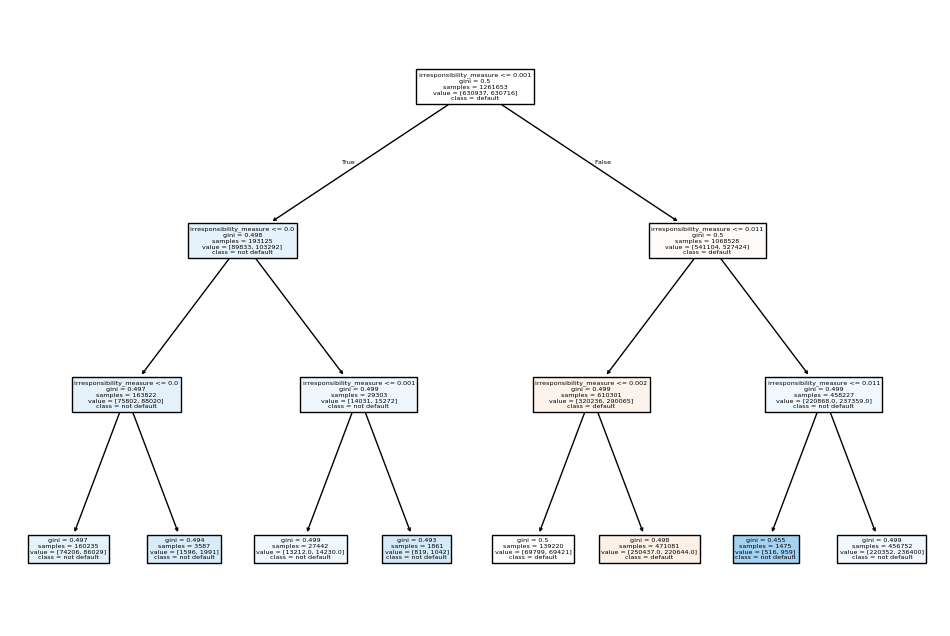

In [24]:
# decision tree:
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.4, random_state=1234)
clf = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(clf, filled=True, feature_names=["irresponsibility_measure"], class_names=["default", "not default"])
plt.show()

In [32]:
# new - factors scores from factor analyzer 
x_constant = sm.add_constant(x_resampled)  

# split test and train set
x_train, x_test, y_train, y_test = train_test_split(x_constant, y_resampled, test_size=0.1, random_state=42)

model = sm.Logit(y_train, x_train).fit()
print(model.summary())

#test
yhat = model.predict(x_test)
# yhat_t = MinMaxScaler(feature_range=(0, 1)).fit_transform(yhat.reshape(-1, 1))
# yhat_t = yhat_t.reshape(yhat.shape)
# predction = list([1 if x > 0.5 else 0 for x in yhat_t])
predction = list(map(round, yhat))
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, predction)
print("Confusion Matrix: \n", cm)
print('Test accuracy = ', accuracy_score(y_test, predction))

Optimization terminated successfully.
         Current function value: 0.693021
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1892480
Model:                          Logit   Df Residuals:                  1892478
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Oct 2024   Pseudo R-squ.:               0.0001826
Time:                        23:56:22   Log-Likelihood:            -1.3115e+06
converged:                       True   LL-Null:                   -1.3118e+06
Covariance Type:            nonrobust   LLR p-value:                3.419e-106
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0181      0.002    -10.826      0.000      -0.021      -0.015
x1             1.2703      0.

In [28]:
from sklearn.linear_model import LogisticRegression

# split test and train set
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.4, random_state=42)
# model = sm.Logit(y_train, x_train).fit()
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(x_train, y_train)
print("coefficient", model.coef_[0])


yhat = model.predict(x_test)
# yhat_t = MinMaxScaler(feature_range=(0, 1)).fit_transform(yhat.reshape(-1, 1))
# yhat_t = yhat_t.reshape(yhat.shape)
# predction = list([1 if x > 0.5 else 0 for x in yhat_t])
predction = list(map(round, yhat))
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, predction)
print("Confusion Matrix: \n", cm)
print('Test accuracy = ', accuracy_score(y_test, predction))

coefficient [1.29969384]
Confusion Matrix: 
 [[289943 130664]
 [280071 140425]]
Test accuracy =  0.5116709844097572
